In [32]:
import numpy as np
import matplotlib.pyplot as plt

%run './../split_step_fourier.ipynb'

# showing figures inline
%matplotlib inline
# plotting options 
font = {'size': 12}
figure_size = (30, 20)
plt.rc('font', **font)
plt.rc('text', usetex=True)

In [61]:
# parameters of the filters
f_symbol = 32e9  # symbol rate (Baud) (Symbols per second)
n_up = 10  # samples per symbol (>1 => oversampling)

r_rc = .33
syms_per_filt = 4  # symbols per filter (plus minus in both directions)
t_sample_rc, rc = get_rc_ir(syms_per_filt, r_rc, f_symbol, n_up)

# modulation scheme and constellation points
M = 2
modulation = {'0': -1, '1': 1}
n_symbol = 30 # number of symbols


# Signalfolge generieren
send_bits = np.random.choice([symbol for symbol in modulation.keys()], size=n_symbol)

In [73]:
## Global Transmission parameters
z_length = 70  # [km]

alpha = 0.2  # Dämpfung [dB/km]
D = 17  # [ps/nm/km]
beta2 = - (D * np.square(1550e-9)) / (2 * np.pi * 3e8) * 1e-3 # [s^2/km] propagation constant, lambda=1550nm is standard single-mode wavelength
gamma = 1.3 # [1/W/km]

In [85]:
# simulate channel for multiple power inputs
sims ={}
for power in np.arange(-5,10):
    send_rc = generate_signal(modulation, t_sample_rc, 1/f_symbol, send_bits, rc, syms_per_filt, power)

    ## Simulation of reference transmission (dz = 0.1 km)
    nz_ref = 100  # steps
    dz_ref = z_length / nz_ref  # [km]

    output_ref = splitstepfourier(send_rc, t_sample_rc, dz_ref, nz_ref, alpha, beta2, gamma)

    d_nz = 1 # d_nz to use in loop
    ## Simulation of fibers with different step sizes
    sim_steps = []
    for nz in np.arange(1, nz_ref+d_nz, step=d_nz):
        dz = z_length / nz
        output = splitstepfourier(send_rc, t_sample_rc, dz, nz, alpha, beta2, gamma)
        sim_steps.append((nz, output))
    
    sims[f"{power}"] = (output_ref, sim_steps)

Text(0.5, 0, 'Steps simulated')

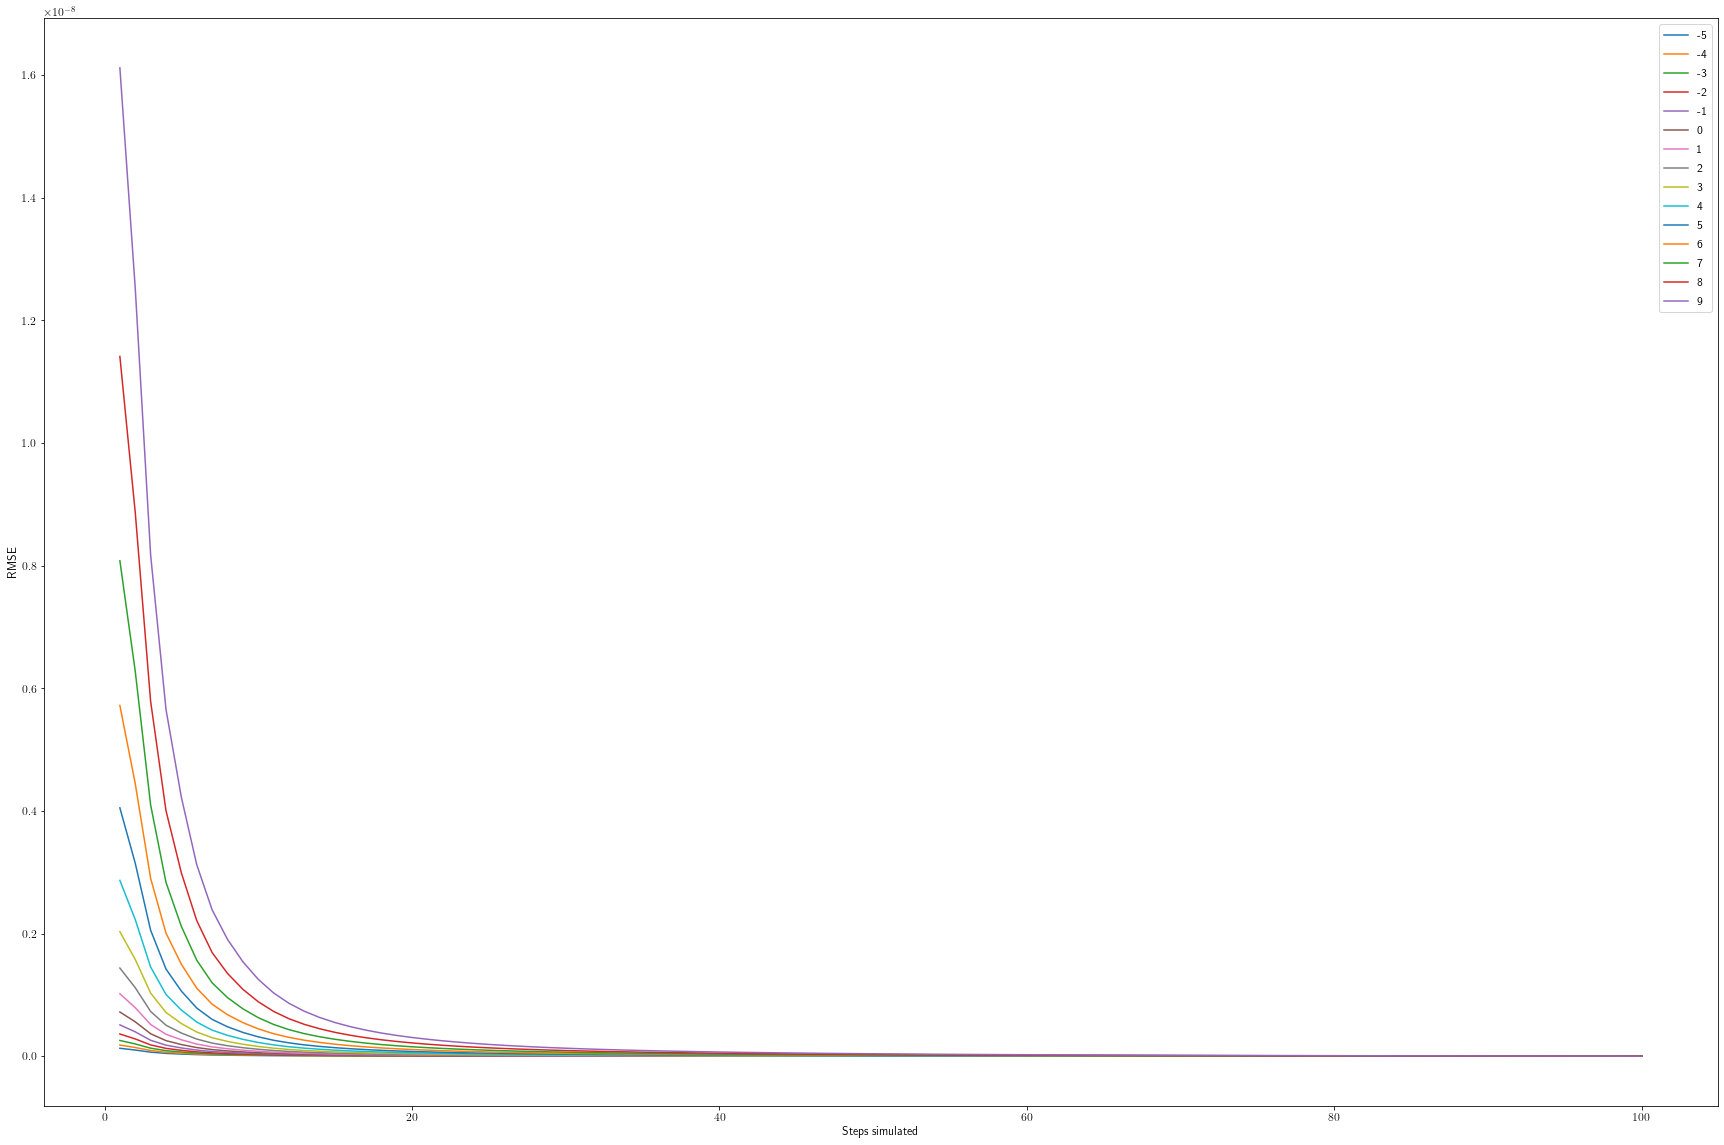

In [88]:
## Evaluation
axes = {}
plots = {}
for key, data in sims.items():
    ref = data[0]
    signal = data[1]
    x_vals = []
    evals = []
    for n_steps, sim_out in signal:
        x_vals.append(n_steps)
        evals.append(abs(calc_rmse(sim_out, ref))) ## fix ref
    axes[key] = x_vals
    plots[key] = evals

    
fig = plt.figure(figsize=figure_size)
for key, val in plots.items():
    plt.plot(np.asarray(axes[key]), val, label=key)

plt.legend(loc='upper right')
plt.ylabel("RMSE")
plt.xlabel("Steps simulated")
